# A Kármán vortex street simulated with a D2Q9 Lattice Boltzmann Method

The code implements a simple D2Q9 LBM, with BGK collision operator and uses a Single Relaxation Time.

The initial Julia implementation comes from [https://github.com/Nappael/JuliaLatticeBoltzmann] (MIT license).

The main reference is of course Philip Mocz's repository [https://github.com/pmocz/latticeboltzmann-python] (GPL3 license).

In [1]:
import Pkg
Pkg.activate(".")
#Pkg.add("PyPlot")
#Pkg.add("Einsum")
#Pkg.add("StaticArrays")
#Pkg.instantiate()

  Activating project at `~/hattivatti`


In [2]:
using PyPlot, Einsum, StaticArrays

# Simulation parameters
const Nx, Ny = 401, 101 # grid points in x and y
const ρ0     = 100      # average density
const Nt     = 1000     # number of timesteps
const Δt     = 1.0
const NL     = 9        # D2Q9 Lattice
const ΔL     = 1.0
const τ      = 0.6      # collision timescale
const ν      = Δt/τ     # appears in the collision equation, precomputing saves a division.

const cxs         = @SVector[0, 0, 1, 1, 1, 0,-1,-1,-1]
const cys         = @SVector[0, 1, 1, 0,-1,-1,-1, 0, 1]
const weights     = @SVector[4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36] # sums to 1
const opposite    = @SVector[1,6,7,8,9,2,3,4,5]
const cylinder    = [(x - Nx/4)^2 + (y - Ny/2)^2 < (Ny/6)^2 for x in 1:Nx, y in 1:Ny]

struct LatticeState{T}
    ρ::Array{T, 2}    # macroscale density
    ux::Array{T, 2}   # macroscale velocity, x component
    uy::Array{T, 2}   # macroscale velocity, y component
    F::Array{T, 3}    # particle distribution function
    Feq::Array{T, 3}  # equillibrium term for collision
    tmp::Array{T, 2}  # place-holder array
end

function LatticeState(Nx,Ny)
    ρ   = zeros(Nx,Ny)
    F   = ones(Nx,Ny,NL)
    Feq = similar(F)
    ux  = similar(ρ)
    uy  = similar(ρ)
    tmp = similar(ρ)

    return LatticeState{Float32}(ρ, ux, uy, F, Feq, tmp)
end

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XaELc/src/init.jl:198


LatticeState

In [3]:
@inbounds function drift!(F::Array{<:Real}, tmp::Array{<:Real})
    for i in 1:NL
        A = @view F[:,:,i]
        circshift!(tmp, A, (cxs[i],0) )
        circshift!(A, tmp, (0,cys[i]) )
    end
end

@inbounds function feq_point(ρ::Real,ux::Real,uy::Real,cx::Int,cy::Int,weight::Real)
    cu = (cx * ux +  cy * uy)
    return ρ * weight * (1. +  3. * cu + 4.5 * cu * cu - 1.5 * (ux*ux + uy*uy))
end

@inbounds function calculate_feq!(Feq::Array{<:Real},
        ρ::Array{<:Real}, ux::Array{<:Real}, uy::Array{<:Real})
    @einsum Feq[i,j,k] = feq_point(ρ[i,j],ux[i,j],uy[i,j],cxs[k],cys[k],weights[k])
end

@inbounds function collision!(F::Array{<:Real},Feq::Array{<:Real})
    F .-= ν .* (F .- Feq)
end

@inbounds function calculate_u!(ux::Array{<:Real}, uy::Array{<:Real},
        F::Array{<:Real}, ρ::Array{<:Real})
    sum!(ρ, F)
    @einsum ux[i,j] = F[i,j,k] * cxs[k] / ρ[i,j]
    @einsum uy[i,j] = F[i,j,k] * cys[k] / ρ[i,j]
end

@inbounds function correct_F!(F::Array{<:Real}, ρ::Array{<:Real})
    @einsum F[i,j,k] = F[i,j,k] * ρ0 / ρ[i,j]
end

function step!(f::LatticeState, Nt::Int, obstacle)
    tmp = similar(obstacle)
    for it in 1:Nt
        drift!(f.F, f.tmp)
        tmp .= obstacle
        calculate_u!(f.ux, f.uy, f.F, f.ρ)
        calculate_feq!(f.Feq, f.ρ, f.ux,f.uy)
        collision!(f.F, f.Feq)
        obstacle[:,opposite] .= tmp
    end
end

@inbounds function init!(f::LatticeState)
    f.F .= ones(Nx, Ny, NL)
    f.F[:,:,:] .+=  0.01randn(Nx, Ny, NL)
    f.F[:,:,4] .+= [2.0 + 0.4cos(2.0π*x/Nx*4.0) for x in 1:Nx, y in 1:Ny]
    sum!(f.ρ, f.F)
    correct_F!(f.F, f.ρ)
end

init! (generic function with 1 method)

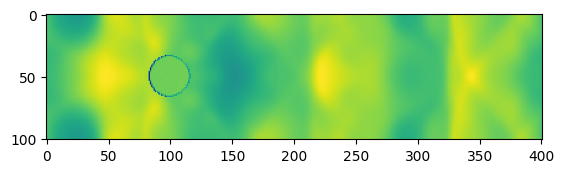

  1.097587 seconds (2.85 M allocations: 143.482 MiB, 5.58% gc time, 99.82% compilation time)
  2.423014 seconds (1.00 k allocations: 13.825 MiB)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/bach/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject <matplotlib.image.AxesImage object at 0x13f9a6790>

In [4]:
problem  = LatticeState(Nx,Ny)
obstacle = view(problem.F, cylinder, 1:NL)
init!(problem)
@time step!(problem,  1, obstacle) # Run simulation
@time step!(problem, Nt, obstacle) # Run simulation

imshow(problem.ρ')

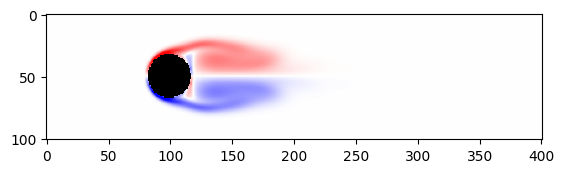

In [5]:
# Apply boundary 
ux = copy(problem.ux)
uy = copy(problem.uy)
ux[cylinder] .= 0.0
uy[cylinder] .= 0.0
velocity  = ux .^2 .+ uy .^ 2
vorticity = (circshift(ux, (0,+1)) .- circshift(ux, (0,-1))) .-
            (circshift(uy, (+1,0)) .- circshift(uy, (-1,0)))
            
vorticity[cylinder] .= NaN
    
bwr = PyPlot.cm.bwr.copy(); bwr.set_bad("black")

imshow(vorticity', cmap=bwr); clim([-.1, +.1])